# Paper example : Landscape of open chromatin in cancers via ATAC-seq (TCGA)

To run this notebook you will need to download the data from [Zenodo](https://doi.org/10.5281/zenodo.10561582):
```sh
wget https://zenodo.org/records/10708208/files/tcga_atac.zip
wget https://zenodo.org/records/10708208/files/GO_files.zip
wget https://zenodo.org/records/10708208/files/genome_annot.zip
unzip GO_files.zip
unzip genome_annot.zip
unzip tcga_atac.zip
```
#### Warning : this example will use > 30GB of memory !

First, load file metadata and dependencies. Note that rows in the metadata are already aligned to be from the same observation. Also set the paths to data folders here !

In [43]:
import sys
sys.path.append("./")
import pandas as pd
import muffin
import numpy as np
import scanpy as sc
import os

path_gencode, path_chromsizes, path_GOfile, path_cancerHallmarks = "genome_annot/gencode.v38.annotation.gtf", "genome_annot/hg38.chrom.sizes.sorted",  "GO_files/hsapiens.GO:BP.name.gmt", "tcga_atac/hallmark_cancer_chg.gmt"

path_table, path_meta = "tcga_atac/atac_table.txt", "tcga_atac/sequencing_stats.csv"

sequencing_metadata = pd.read_csv(path_meta, 
                                  sep="\t", index_col=0)
# Avoids warning spam
os.environ['PYTHONWARNINGS']='ignore'





You can set plot settings for muffin :

In [44]:
try:
    os.mkdir("atac_tcga_results/")
except FileExistsError:
    pass
muffin.params["autosave_plots"] = "atac_tcga_results/"
muffin.params["figure_dpi"] = 200
muffin.params["autosave_format"] = ".pdf"
sc.set_figure_params(dpi=200, dpi_save=300, vector_friendly=False)
sc.set_figure_params(dpi=200, dpi_save=300, vector_friendly=False)
sc.settings.autosave = True
sc.settings.figdir = "atac_tcga_results/"
# Makes pdf font editable with pdf editors
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

/shared/projects/pol2_chipseq/pkg/miniconda3/envs/muffin_test/lib/python3.10/site-packages/scanpy/_settings.py:450: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  IPython.display.set_matplotlib_formats(*ipython_format)


We can load the dataset using pandas and the helper functions, then add additionnal metadata :

In [45]:
dataset_tsv = pd.read_csv(path_table, sep="\t")
dataset = muffin.load.dataset_from_arrays(dataset_tsv.iloc[:, 7:].values.T, row_names=dataset_tsv.columns[7:],
                                          col_names=dataset_tsv["name"])
dataset.var = dataset_tsv.iloc[:, :7]
dataset.obs["Cancer type"] = [s[:4] for s in dataset.obs_names]
dataset.obs["FRIP"] = sequencing_metadata["FRIP"].values
dataset.obs["Subtype"] = sequencing_metadata["BRCA_pam50"].values
dataset.obs["Subtype"][dataset.obs["Subtype"]=="Normal"] = np.nan
dataset.var.rename(columns={"seqnames":"Chromosome","start":"Start","end":"End"}, inplace=True)

/tmp/ipykernel_14683/966778014.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset.obs["Subtype"][dataset.obs["Subtype"]=="Normal"] = np.nan


The dataset is in an anndata object, which allows for an easy annotation of the count matrix, and the storage of different count transforms. Results will be stored in this object.

In [46]:
print(dataset)

AnnData object with n_obs × n_vars = 796 × 562709
    obs: 'Cancer type', 'FRIP', 'Subtype'
    var: 'Chromosome', 'Start', 'End', 'name', 'score', 'annotation', 'GC'


Here, we can re-name our features (columns of the count matrix) to the nearest gene's name for convenience in downstream analyses. The dataset variable annotation has been automatically annotated with genomic locations in the previous step. Note that the gsea_obj object also provides functions for gene set enrichment of nearby genes.

In [47]:
gsea_obj = muffin.great.pyGREAT(path_gencode, path_chromsizes, path_GOfile)
dataset.var_names = gsea_obj.label_by_nearest_gene(dataset.var[["Chromosome","Start","End"]]).astype(str)

/shared/ifbstor1/projects/pol2_chipseq/newPkg/muffin/great.py:152: FutureWarning: Allowing arbitrary scalar fill_value in SparseDtype is deprecated. In a future version, the fill_value must be a valid value for the SparseDtype.subtype.
  self.mat = pd.DataFrame.sparse.from_spmatrix(csr_array((data, (geneFa, goFa)), shape=(len(genes), len(gos))).T,
/shared/projects/pol2_chipseq/pkg/miniconda3/envs/muffin_test/lib/python3.10/site-packages/pyranges/methods/init.py:60: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return {k: v for k, v in df.groupby(grpby_key)}
/shared/projects/pol2_chipseq/pkg/miniconda3/envs/muffin_test/lib/python3.10/site-packages/pyranges/methods/init.py:60: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass o

Here, we set up the design matrix of the linear model. If you do not want to regress any confounding factors leave it to a column array of ones as in the example. Note that it can have a tendency to "over-regress" and remove biological signal as it is a simple linear correction.

In [48]:
design = np.ones((dataset.X.shape[0],1))
muffin.load.set_design_matrix(dataset, design)

Now, we are going to normalize library sizes using the scran approach, which is well suited to a large number of observations and small counts with many zeroes. We are also going to remove features with very low signal (note that this is mandatory to remove all zero counts).

In [49]:
detectable = muffin.tools.trim_low_counts(dataset)
dataset = dataset[:, detectable]
muffin.tools.compute_size_factors(dataset, method="deseq")

/shared/ifbstor1/projects/pol2_chipseq/newPkg/muffin/tools.py:435: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  dataset.obs["size_factors"] = (values / np.mean(values)).astype("float32")


AnnData object with n_obs × n_vars = 796 × 562709
    obs: 'Cancer type', 'FRIP', 'Subtype', 'size_factors'
    var: 'Chromosome', 'Start', 'End', 'name', 'score', 'annotation', 'GC'
    obsm: 'design'

The next step is to fit the mean-variance relationship and compute residuals to the fitted Negative Binomial model.

[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done 248 tasks      | elapsed:   45.3s
[Parallel(n_jobs=16)]: Done 2000 out of 2000 | elapsed:   48.4s finished
[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done 9248 tasks      | elapsed:   31.4s
[Parallel(n_jobs=16)]: Done 86048 tasks      | elapsed:  1.8min
[Parallel(n_jobs=16)]: Done 214048 tasks      | elapsed:  4.0min
[Parallel(n_jobs=16)]: Done 393248 tasks      | elapsed:  7.1min
[Parallel(n_jobs=16)]: Done 561638 tasks      | elapsed: 10.0min
[Parallel(n_jobs=16)]: Done 562709 out of 562709 | elapsed: 10.0min finished
/shared/ifbstor1/projects/pol2_chipseq/newPkg/muffin/tools.py:537: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array w

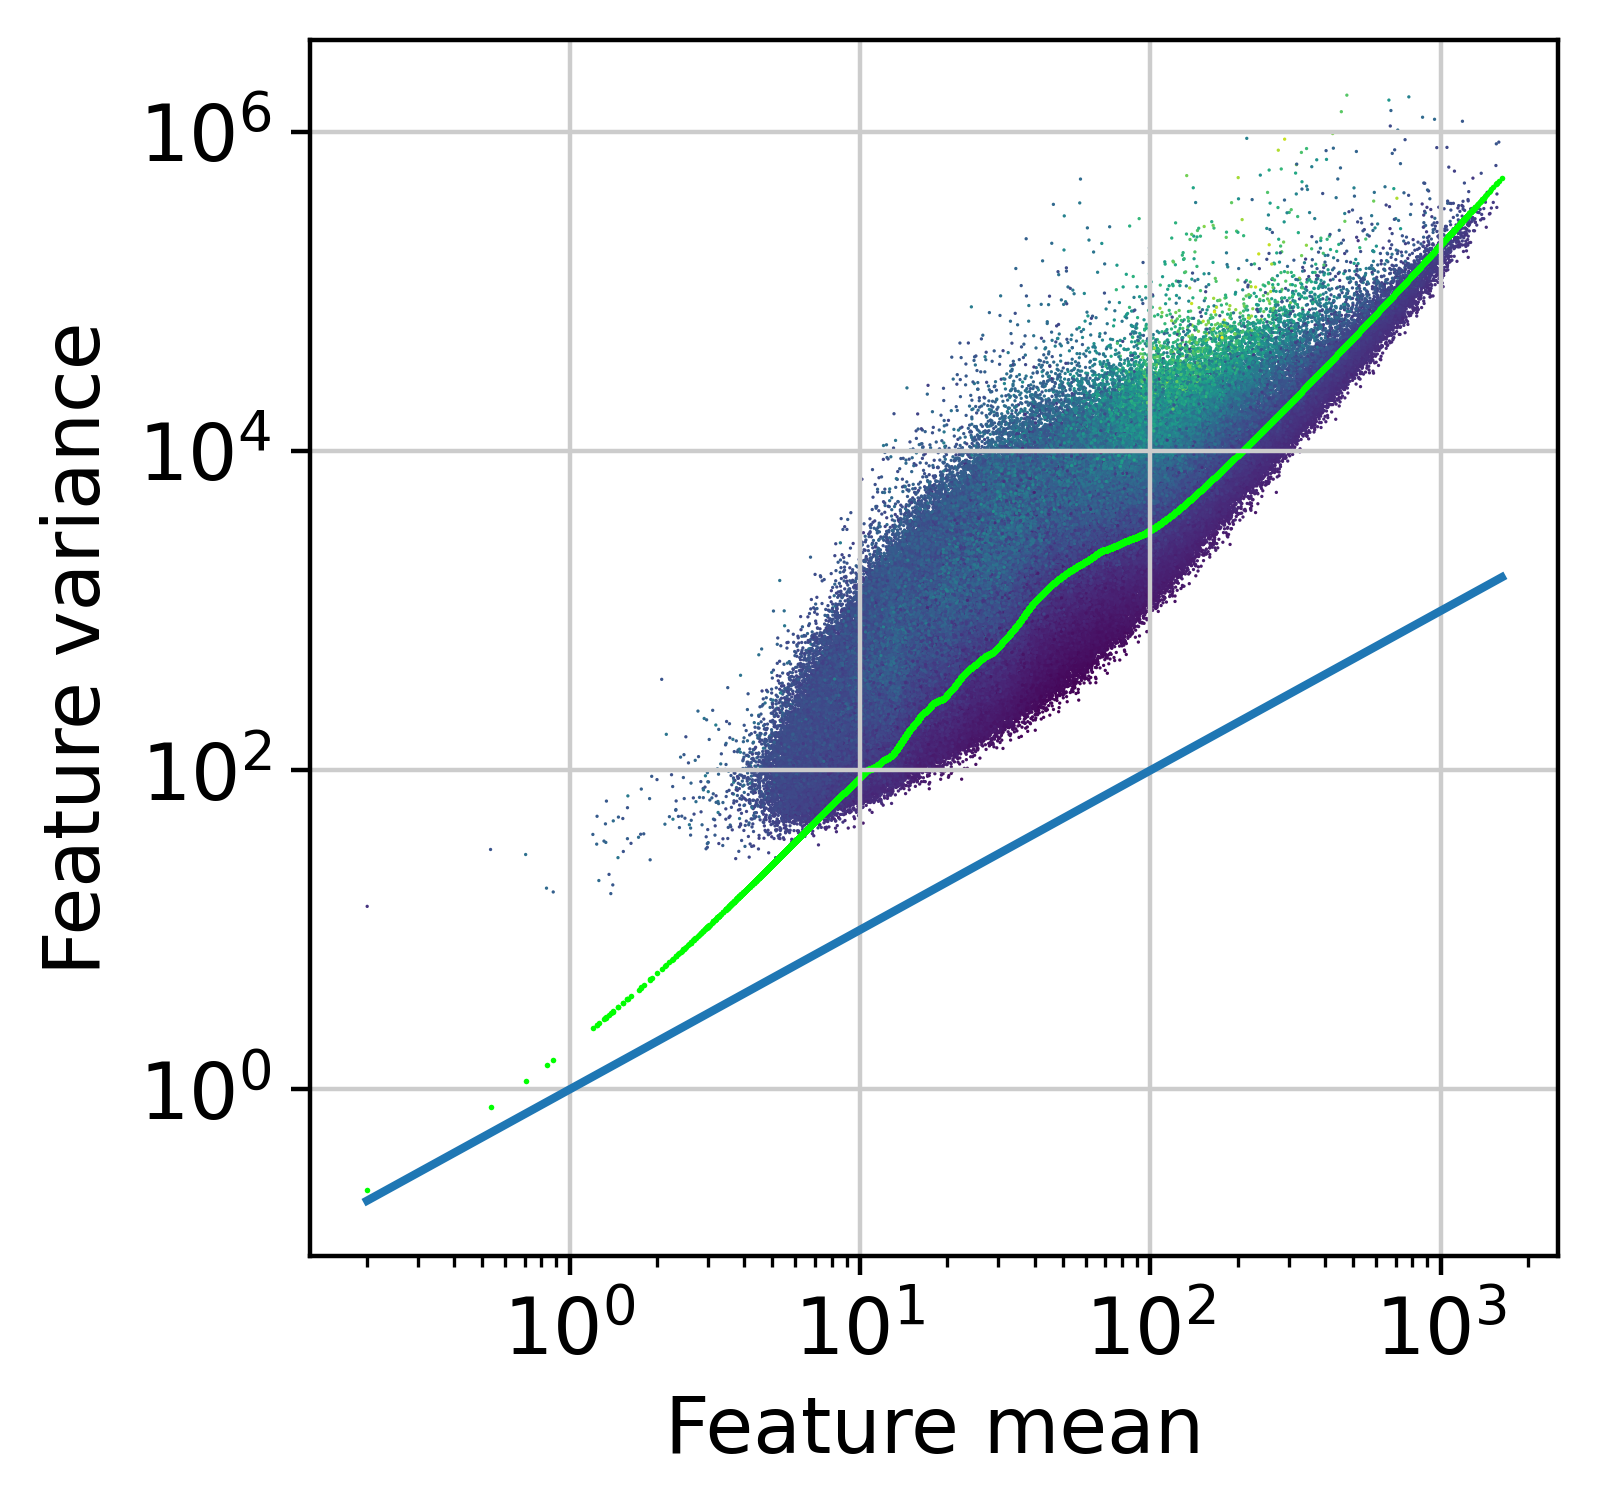

AnnData object with n_obs × n_vars = 796 × 562709
    obs: 'Cancer type', 'FRIP', 'Subtype', 'size_factors'
    var: 'Chromosome', 'Start', 'End', 'name', 'score', 'annotation', 'GC', 'means', 'variances', 'reg_alpha'
    obsm: 'design'
    layers: 'residuals'

In [50]:
muffin.tools.compute_residuals(dataset, maxThreads=16)

Next, we perform dimensionnality reduction with PCA (automatically finding the optimal dimensionnality) and UMAP.

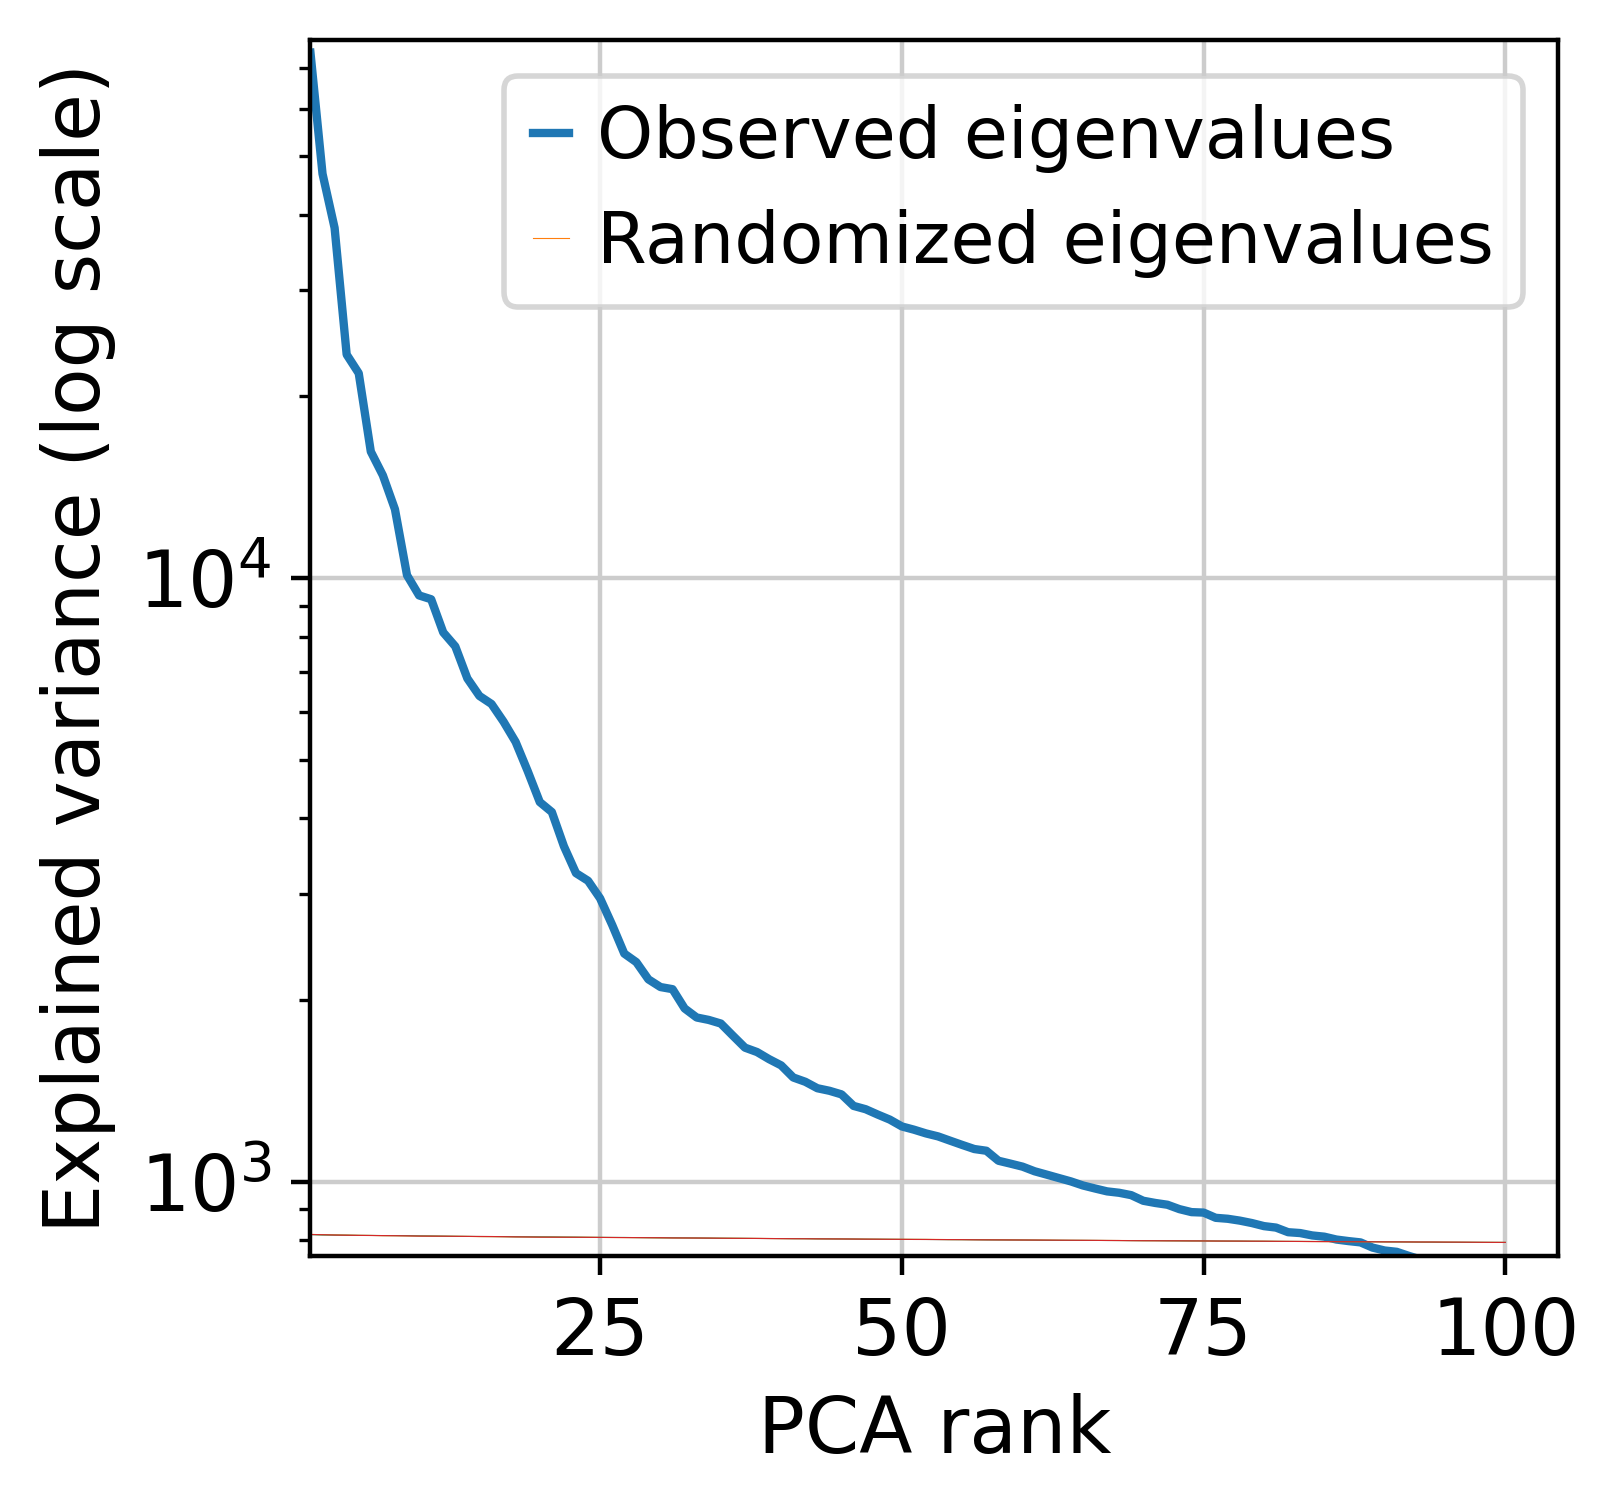

/shared/projects/pol2_chipseq/pkg/miniconda3/envs/muffin_test/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


AnnData object with n_obs × n_vars = 796 × 562709
    obs: 'Cancer type', 'FRIP', 'Subtype', 'size_factors'
    var: 'Chromosome', 'Start', 'End', 'name', 'score', 'annotation', 'GC', 'means', 'variances', 'reg_alpha'
    uns: 'pca'
    obsm: 'design', 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'residuals'

In [51]:
muffin.tools.compute_pa_pca(dataset, max_rank=100, plot=True)
# Reduce spacing between points a bit to improve readability
muffin.tools.compute_umap(dataset, umap_params={"min_dist":0.5, "n_neighbors":30})

Display the results. Note that we can use scanpy functions here!

/shared/projects/pol2_chipseq/pkg/miniconda3/envs/muffin_test/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/shared/projects/pol2_chipseq/pkg/miniconda3/envs/muffin_test/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/shared/projects/pol2_chipseq/pkg/miniconda3/envs/muffin_test/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


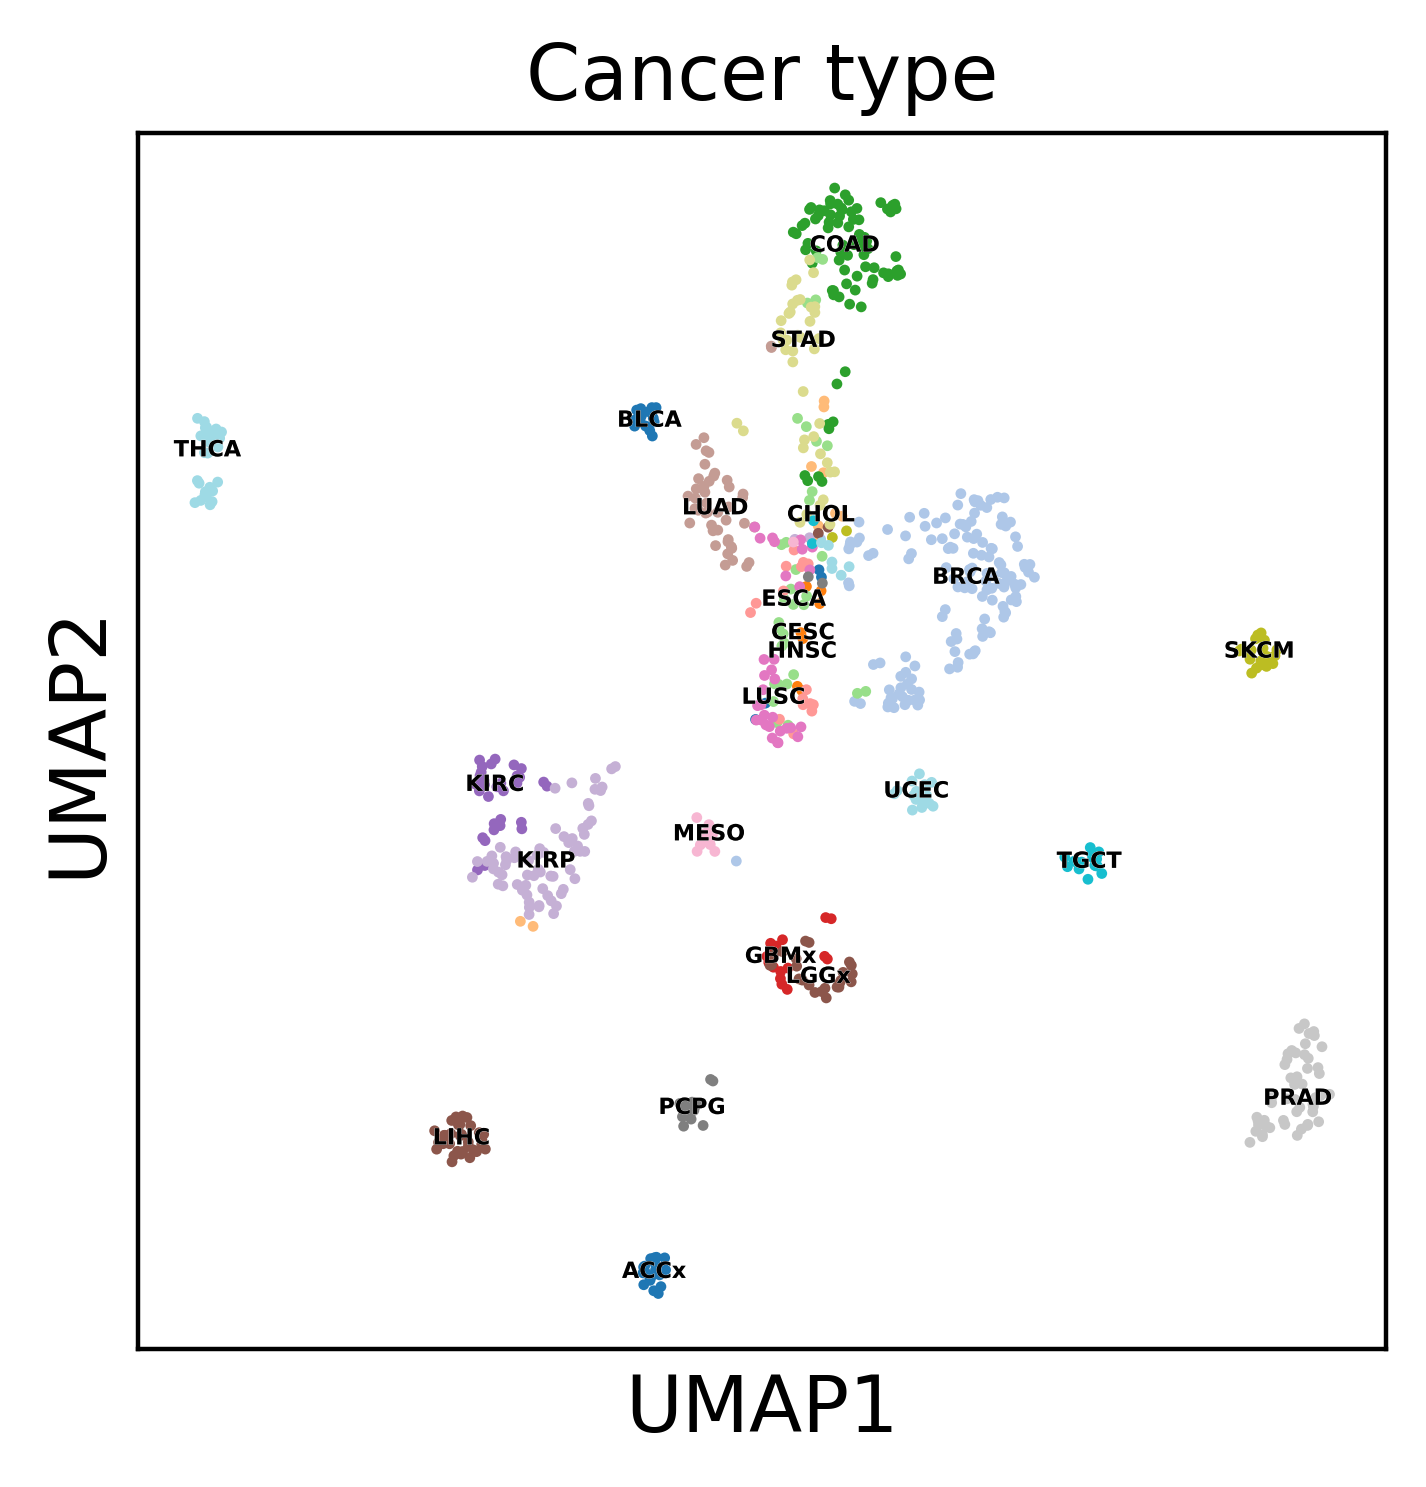

/shared/projects/pol2_chipseq/pkg/miniconda3/envs/muffin_test/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/shared/projects/pol2_chipseq/pkg/miniconda3/envs/muffin_test/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/shared/projects/pol2_chipseq/pkg/miniconda3/envs/muffin_test/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


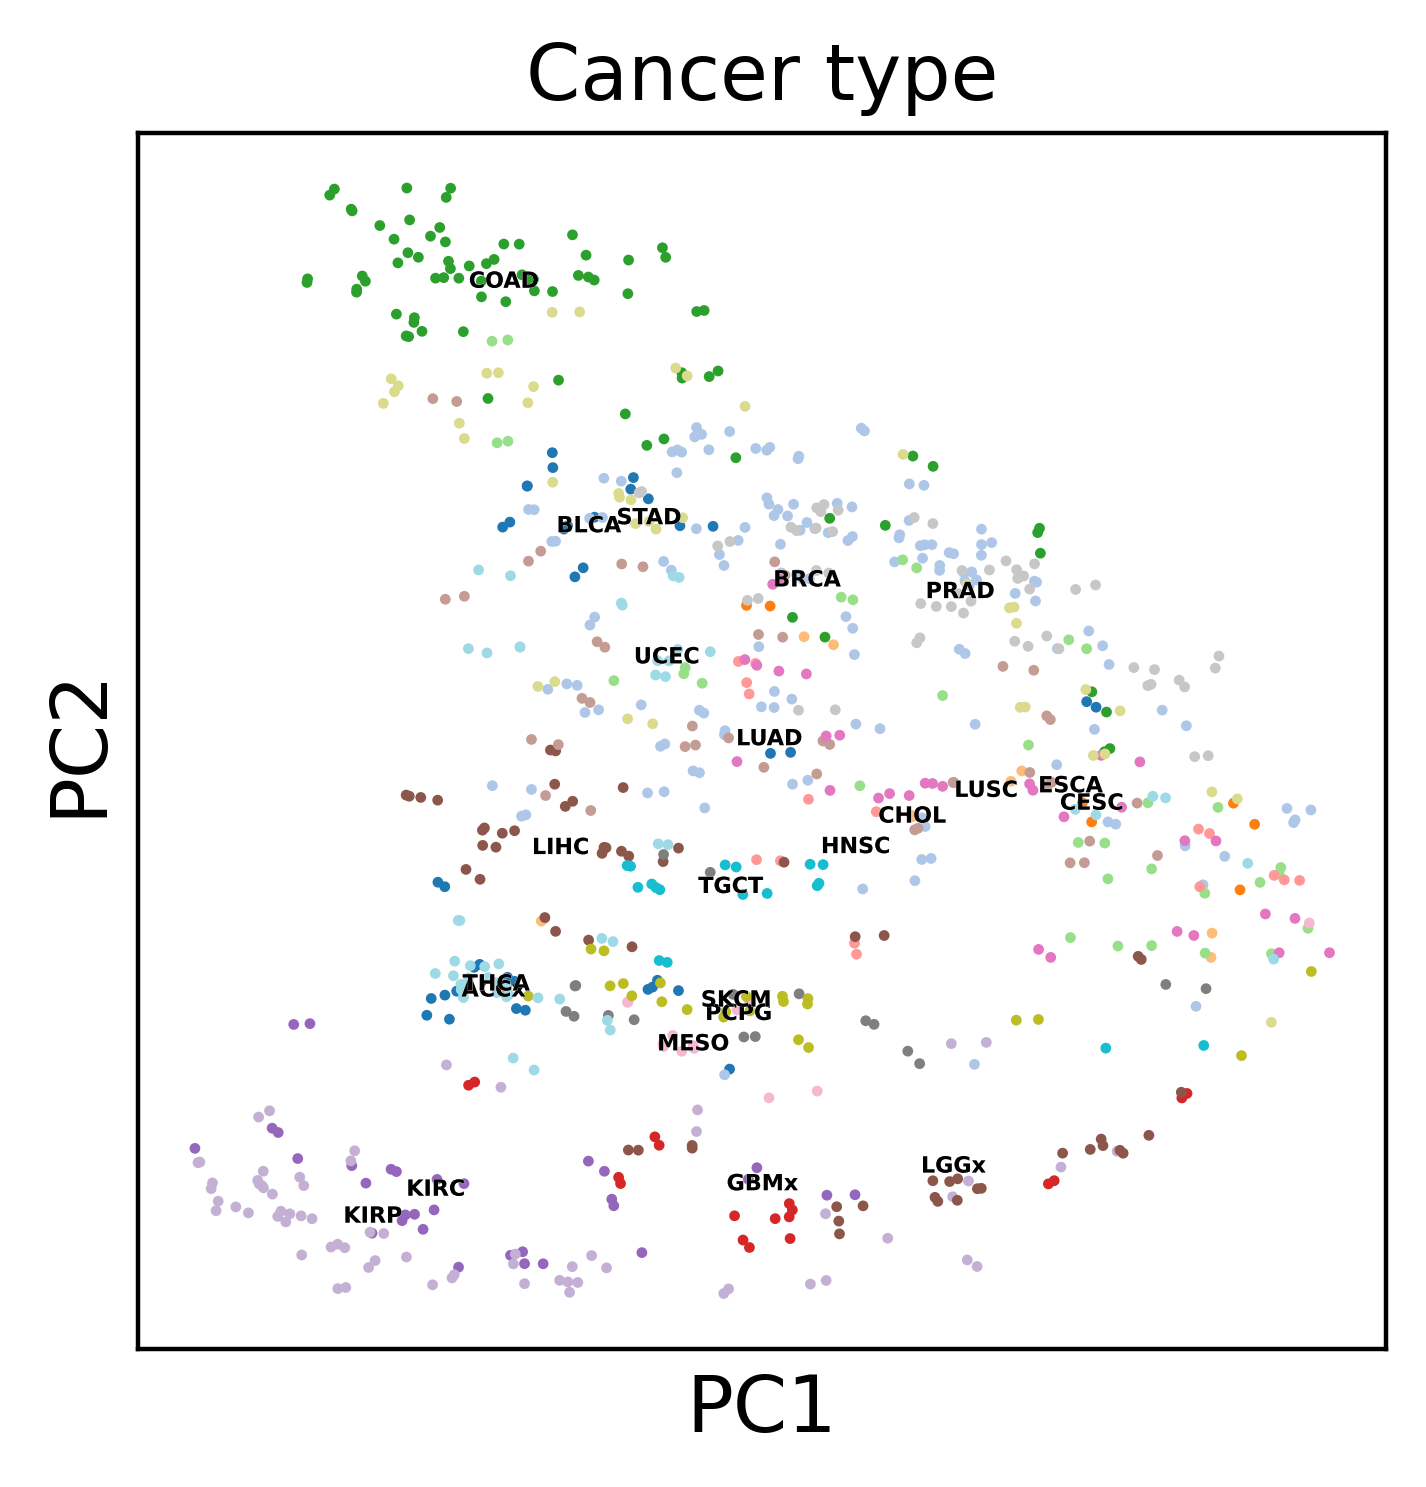

In [52]:
# Append cell type info to the dataset
sc.pl.umap(dataset, color='Cancer type', legend_loc='on data',
                legend_fontsize=4, legend_fontoutline=0.1, s=15.0,
                palette='tab20', save=f"umap_all_tcga.pdf")
sc.pl.pca(dataset, color='Cancer type', legend_loc='on data',
                legend_fontsize=4, legend_fontoutline=0.1, s=15.0,
                palette='tab20')

We can also use heatmaps, even if we have a large number of observations and features :

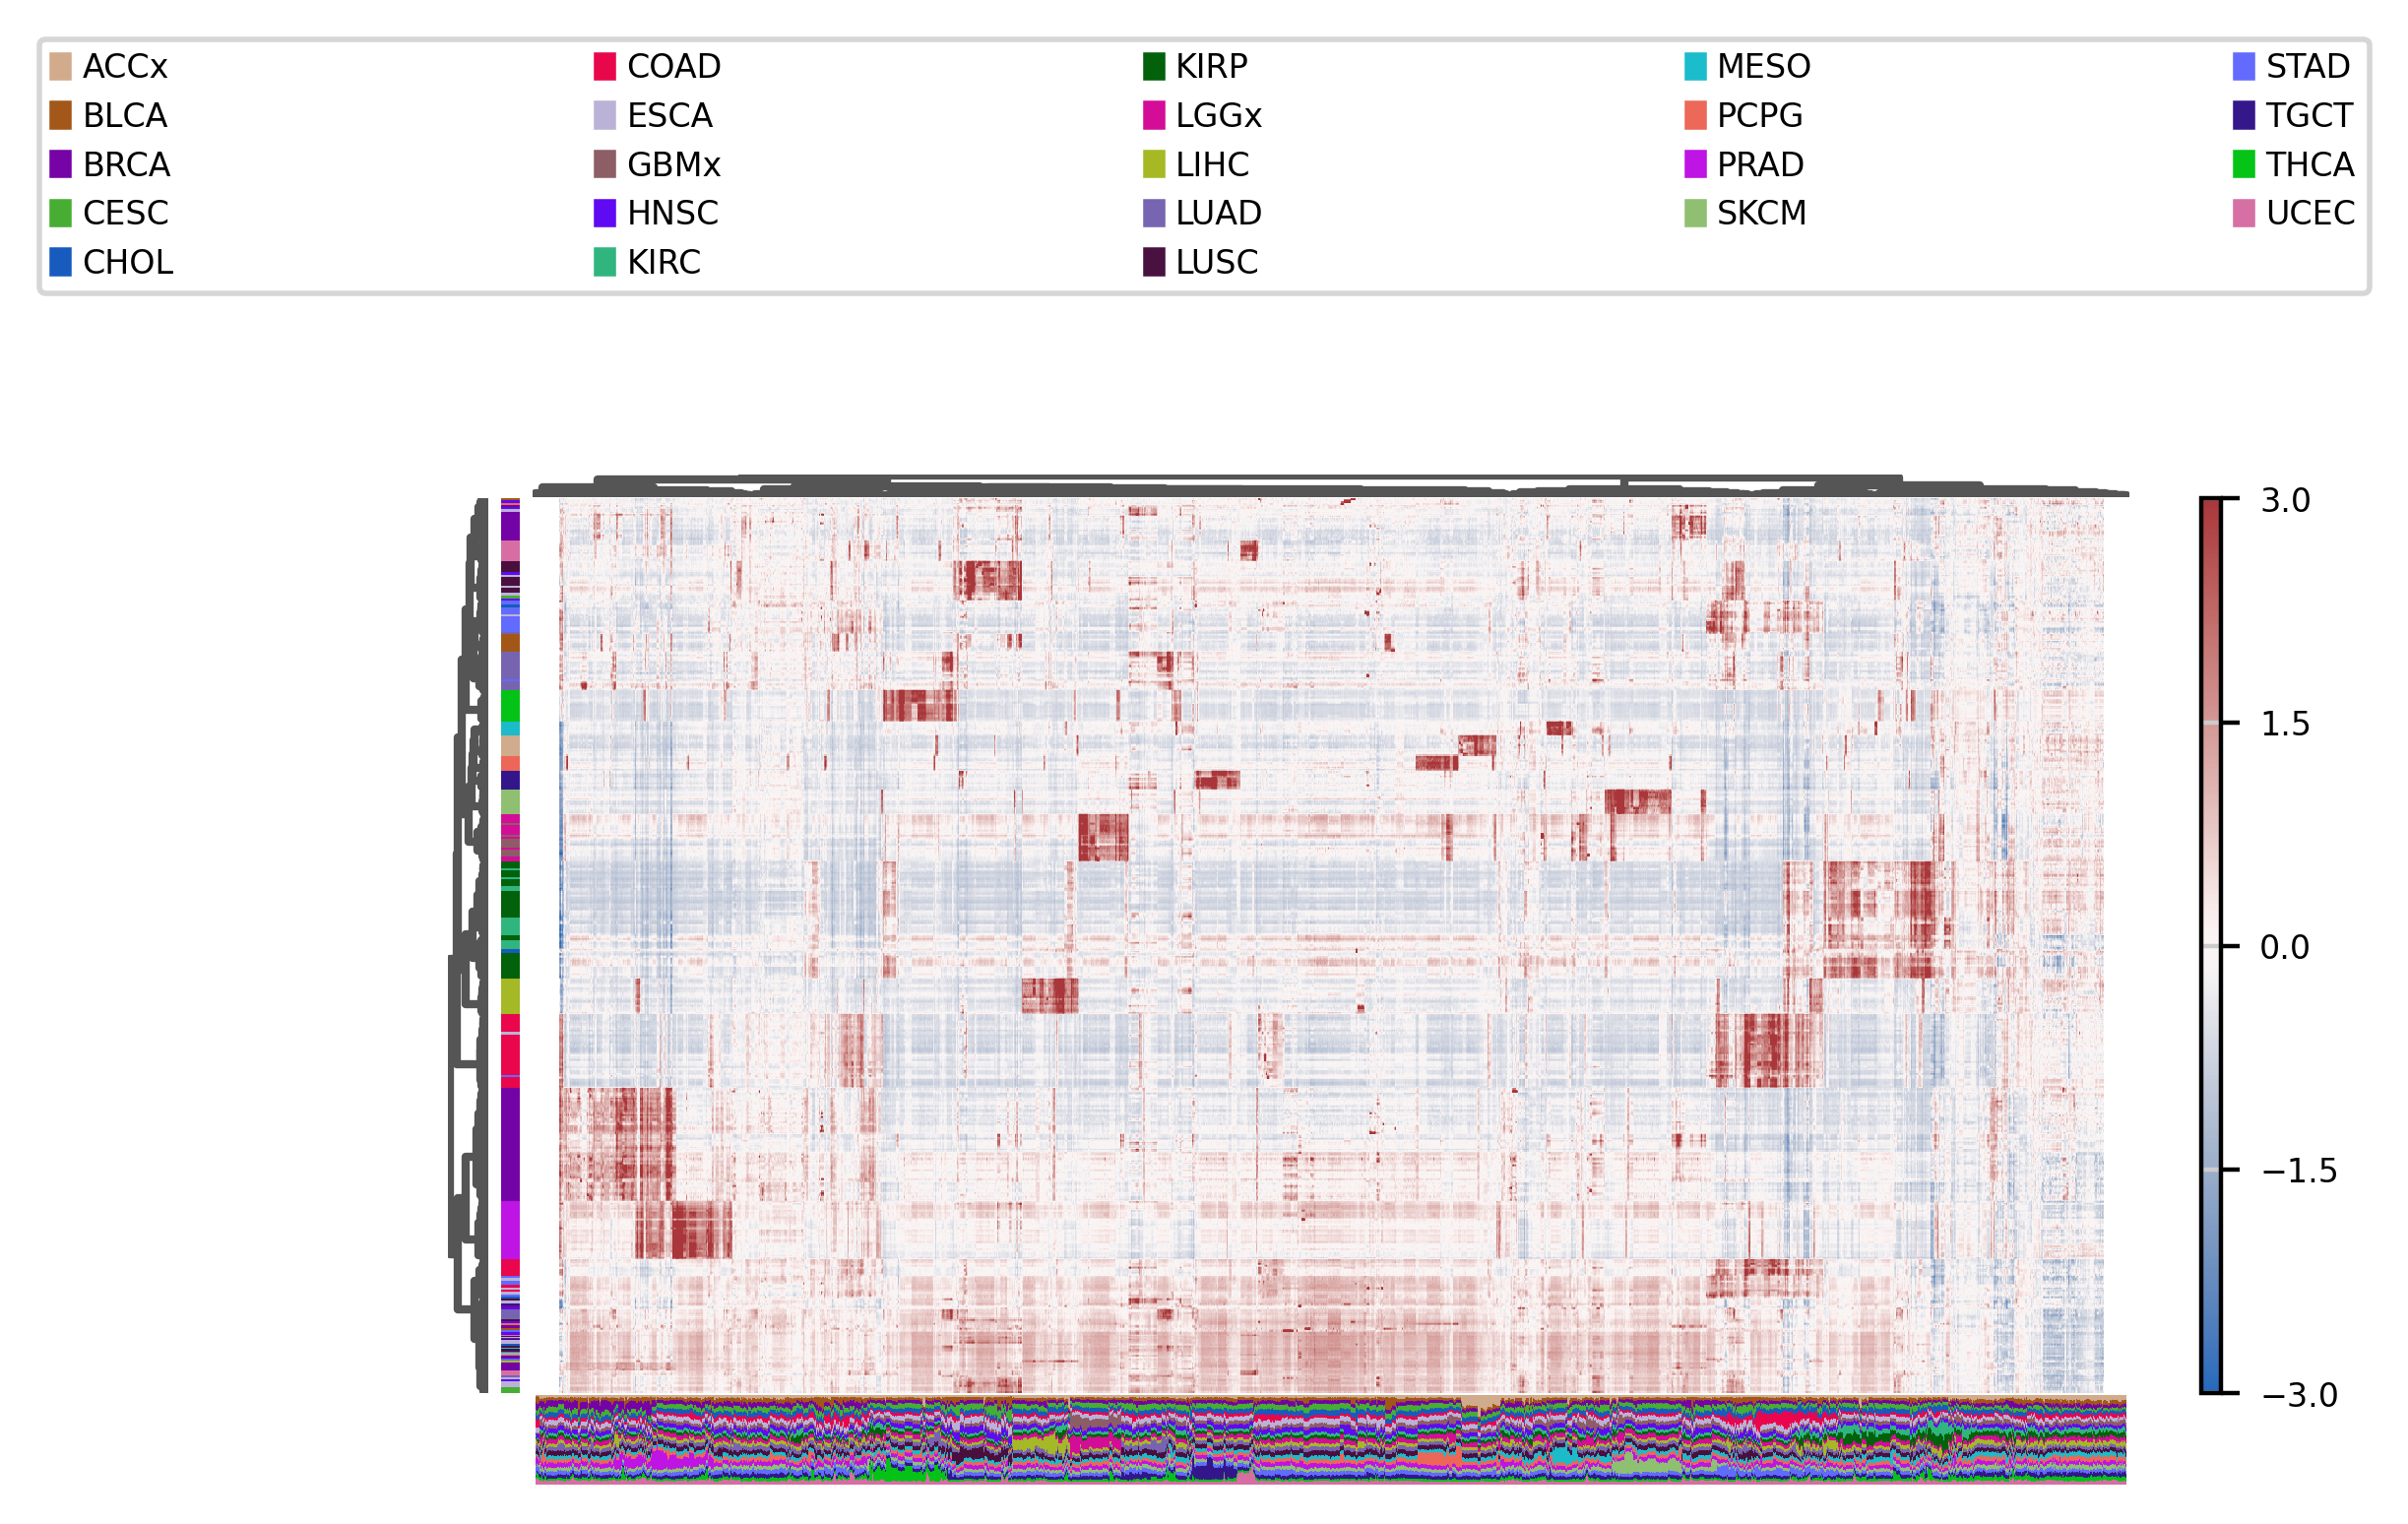

In [53]:
fig, ax = muffin.plots.mega_heatmap(dataset, label_col="Cancer type", layer="residuals", vmin=-3, vmax=3)

Let's focus on Breast cancer subtypes:

/shared/projects/pol2_chipseq/pkg/miniconda3/envs/muffin_test/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/shared/projects/pol2_chipseq/pkg/miniconda3/envs/muffin_test/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/shared/projects/pol2_chipseq/pkg/miniconda3/envs/muffin_test/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


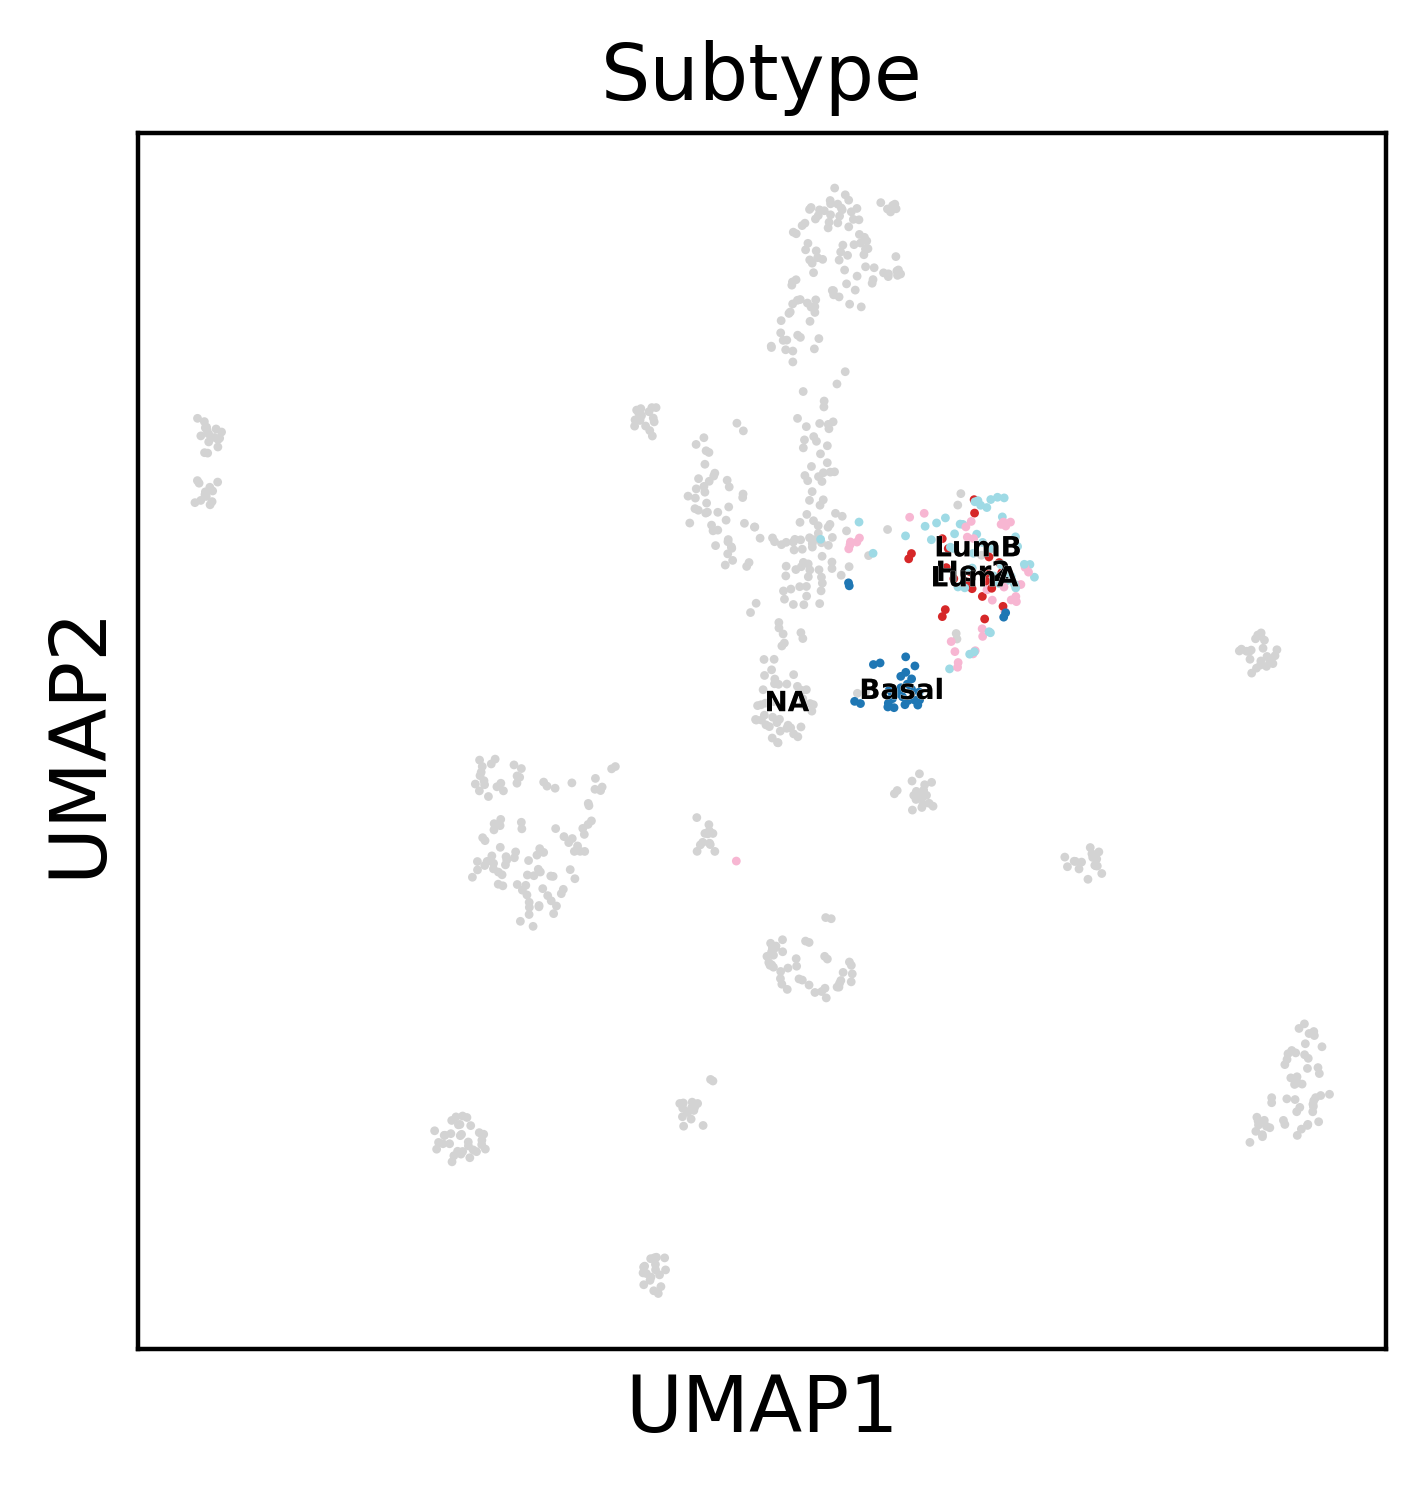

In [54]:
sc.pl.umap(dataset, color='Subtype', legend_loc='on data',
            legend_fontsize=5, legend_fontoutline=0.1, s=10.0, 
            palette='tab20')

In [55]:
# Only BRCA subtype info is specified
brca_subset = dataset[~dataset.obs["Subtype"].isna()]

Find specific markers for each subtype using logistic regression coefficients.

In [56]:
from sklearn.preprocessing import StandardScaler
brca_subset.layers["scaled"] = StandardScaler().fit_transform(brca_subset.layers["residuals"])
sc.tl.rank_genes_groups(brca_subset, 'Subtype', use_raw=False, layer="scaled",
                        method='logreg', class_weight="balanced")

/tmp/ipykernel_14683/2049856826.py:2: ImplicitModificationWarning: Setting element `.layers['scaled']` of view, initializing view as actual.
  brca_subset.layers["scaled"] = StandardScaler().fit_transform(brca_subset.layers["residuals"])


We can see some known markers (ERBB2 is the main marker of Her2+ breast cancer, MAP3K3 is a part of the MAPK kinase and known to be over-expressed in Luminal cancers).

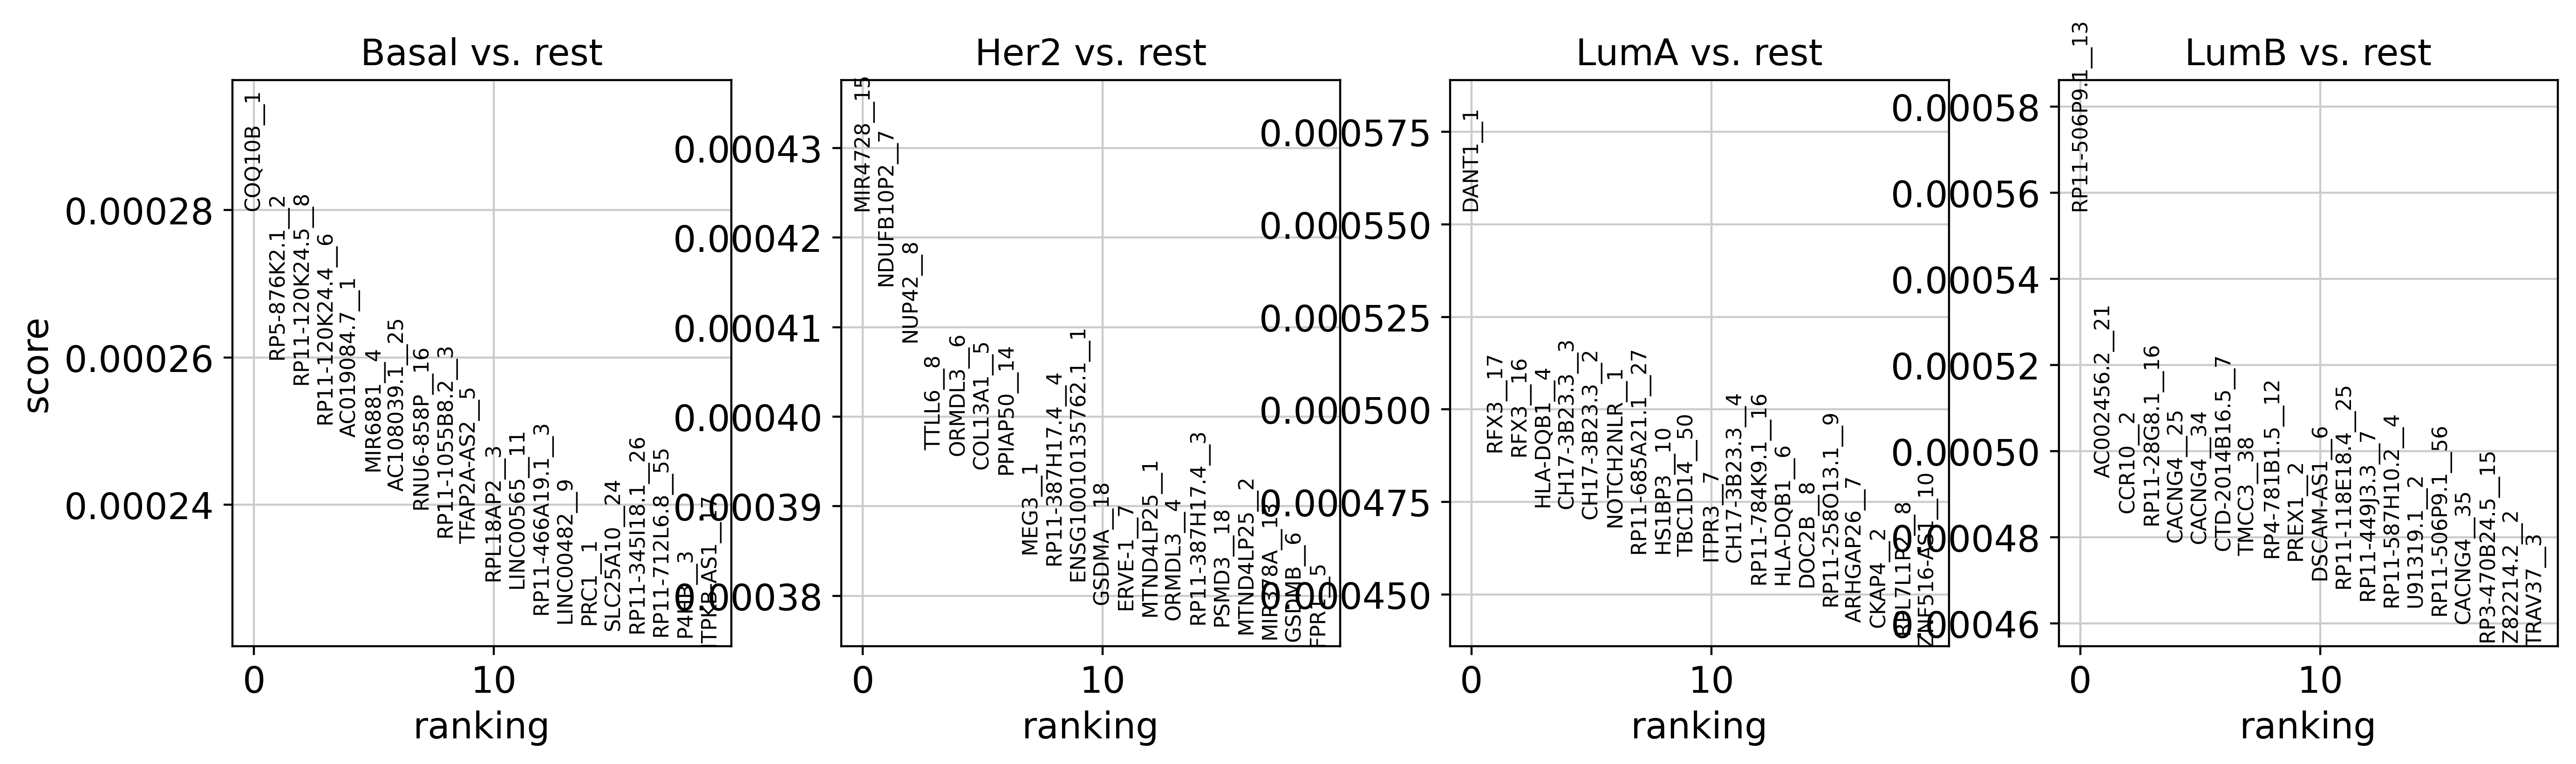

In [57]:
sc.pl.rank_genes_groups(brca_subset, sharey=False)

/shared/projects/pol2_chipseq/pkg/miniconda3/envs/muffin_test/lib/python3.10/site-packages/scanpy/plotting/_anndata.py:1067: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if isinstance(groupby, str) and is_categorical_dtype(adata.obs[groupby]):
/shared/projects/pol2_chipseq/pkg/miniconda3/envs/muffin_test/lib/python3.10/site-packages/scanpy/tools/_dendrogram.py:105: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(adata.obs[group]):
/shared/projects/pol2_chipseq/pkg/miniconda3/envs/muffin_test/lib/python3.10/site-packages/scanpy/tools/_dendrogram.py:133: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence th

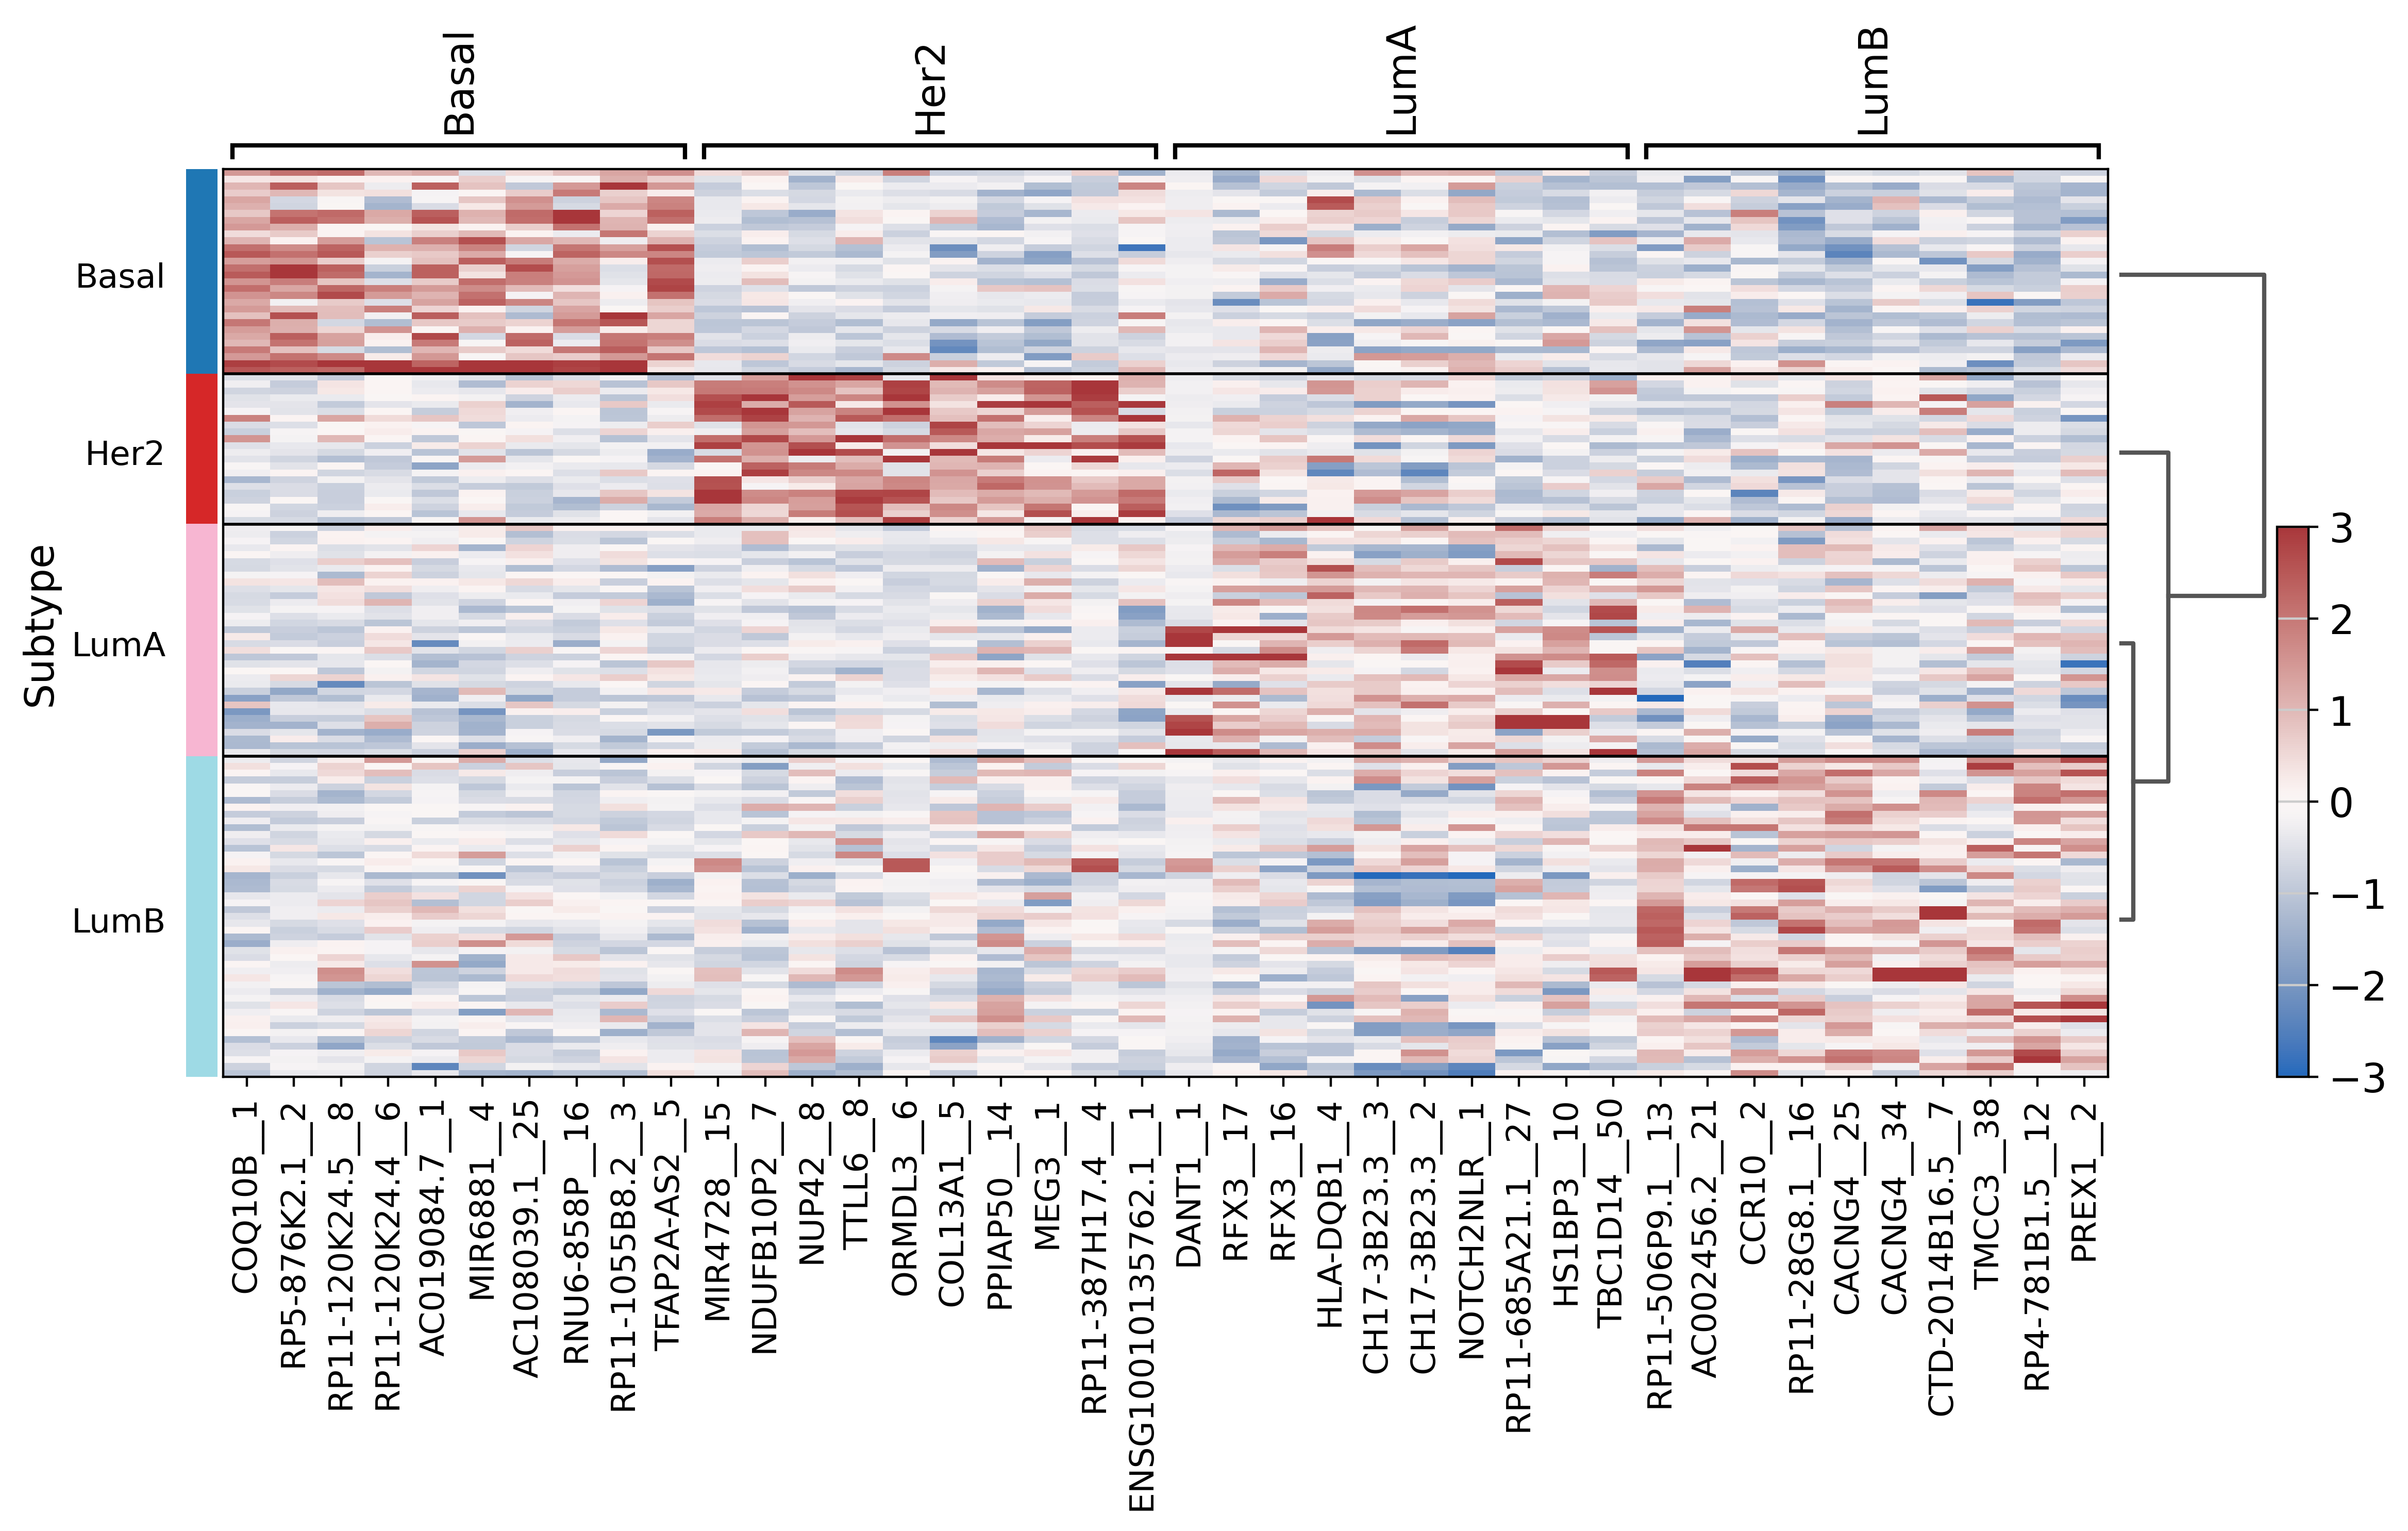

In [58]:
# Ugly hack to solve an issue with scanpy logreg that does not output all fields
brca_subset.uns["rank_genes_groups"]["logfoldchanges"] = brca_subset.uns["rank_genes_groups"]["scores"]
brca_subset.uns["rank_genes_groups"]["pvals"] = brca_subset.uns["rank_genes_groups"]["scores"]
brca_subset.uns["rank_genes_groups"]["pvals_adj"] = brca_subset.uns["rank_genes_groups"]["scores"]
sc.pl.rank_genes_groups_heatmap(brca_subset, layer="scaled", use_raw=False, vmin=-3, vmax=3, cmap="vlag")

We can save our work to avoid recomputing everything. It can easily be re-loaded using :  scanpy.read_h5ad(path). We can also see that our dataset carries much more data than at the start.

In [59]:
dataset.write("atac_tcga_results/dataset.h5ad")
print(dataset)

AnnData object with n_obs × n_vars = 796 × 562709
    obs: 'Cancer type', 'FRIP', 'Subtype', 'size_factors'
    var: 'Chromosome', 'Start', 'End', 'name', 'score', 'annotation', 'GC', 'means', 'variances', 'reg_alpha'
    uns: 'pca', 'Cancer type_colors', 'Subtype_colors'
    obsm: 'design', 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'residuals'


Let's find if our cancer subtypes markers are located near genes involved in cancer hallmarks.

In [60]:
enricher_hallmarks = muffin.great.pyGREAT(path_gencode, path_chromsizes, path_cancerHallmarks)

/shared/ifbstor1/projects/pol2_chipseq/newPkg/muffin/great.py:152: FutureWarning: Allowing arbitrary scalar fill_value in SparseDtype is deprecated. In a future version, the fill_value must be a valid value for the SparseDtype.subtype.
  self.mat = pd.DataFrame.sparse.from_spmatrix(csr_array((data, (geneFa, goFa)), shape=(len(genes), len(gos))).T,


In [61]:
import seaborn as sns
subtypes = np.sort(np.unique(brca_subset.obs["Subtype"].values))
enrich_per_subtype = dict()
for s in subtypes:
    print(s)
    bg = brca_subset.var[["Chromosome", "Start", "End"]]
    # Take the top 5% markers. 
    # Unfortunately due to the number of features the p-value computation is untractable for the logistic regression
    query = brca_subset.var.loc[brca_subset.uns["rank_genes_groups"]["names"][s][:int(brca_subset.shape[1]*0.05+1)]][["Chromosome", "Start", "End"]]
    enrich_per_subtype[s] = enricher_hallmarks.find_enriched(query, bg, cores=16, max_genes=1e9)

Basal


/shared/projects/pol2_chipseq/pkg/miniconda3/envs/muffin_test/lib/python3.10/site-packages/pyranges/methods/init.py:60: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return {k: v for k, v in df.groupby(grpby_key)}
/shared/projects/pol2_chipseq/pkg/miniconda3/envs/muffin_test/lib/python3.10/site-packages/pyranges/methods/init.py:60: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return {k: v for k, v in df.groupby(grpby_key)}
/shared/projects/pol2_chipseq/pkg/miniconda3/envs/muffin_test/lib/python3.10/site-packages/pyranges/methods/init.py:60: FutureWarning: The default of observed=False is deprecated and will 

Her2


/shared/projects/pol2_chipseq/pkg/miniconda3/envs/muffin_test/lib/python3.10/site-packages/pyranges/methods/init.py:60: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return {k: v for k, v in df.groupby(grpby_key)}
/shared/projects/pol2_chipseq/pkg/miniconda3/envs/muffin_test/lib/python3.10/site-packages/pyranges/methods/init.py:60: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return {k: v for k, v in df.groupby(grpby_key)}
/shared/projects/pol2_chipseq/pkg/miniconda3/envs/muffin_test/lib/python3.10/site-packages/pyranges/methods/init.py:60: FutureWarning: The default of observed=False is deprecated and will 

LumA


/shared/projects/pol2_chipseq/pkg/miniconda3/envs/muffin_test/lib/python3.10/site-packages/pyranges/methods/init.py:60: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return {k: v for k, v in df.groupby(grpby_key)}
/shared/projects/pol2_chipseq/pkg/miniconda3/envs/muffin_test/lib/python3.10/site-packages/pyranges/methods/init.py:60: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return {k: v for k, v in df.groupby(grpby_key)}
/shared/projects/pol2_chipseq/pkg/miniconda3/envs/muffin_test/lib/python3.10/site-packages/pyranges/methods/init.py:60: FutureWarning: The default of observed=False is deprecated and will 

LumB


/shared/projects/pol2_chipseq/pkg/miniconda3/envs/muffin_test/lib/python3.10/site-packages/pyranges/methods/init.py:60: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return {k: v for k, v in df.groupby(grpby_key)}
/shared/projects/pol2_chipseq/pkg/miniconda3/envs/muffin_test/lib/python3.10/site-packages/pyranges/methods/init.py:60: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return {k: v for k, v in df.groupby(grpby_key)}
/shared/projects/pol2_chipseq/pkg/miniconda3/envs/muffin_test/lib/python3.10/site-packages/pyranges/methods/init.py:60: FutureWarning: The default of observed=False is deprecated and will 

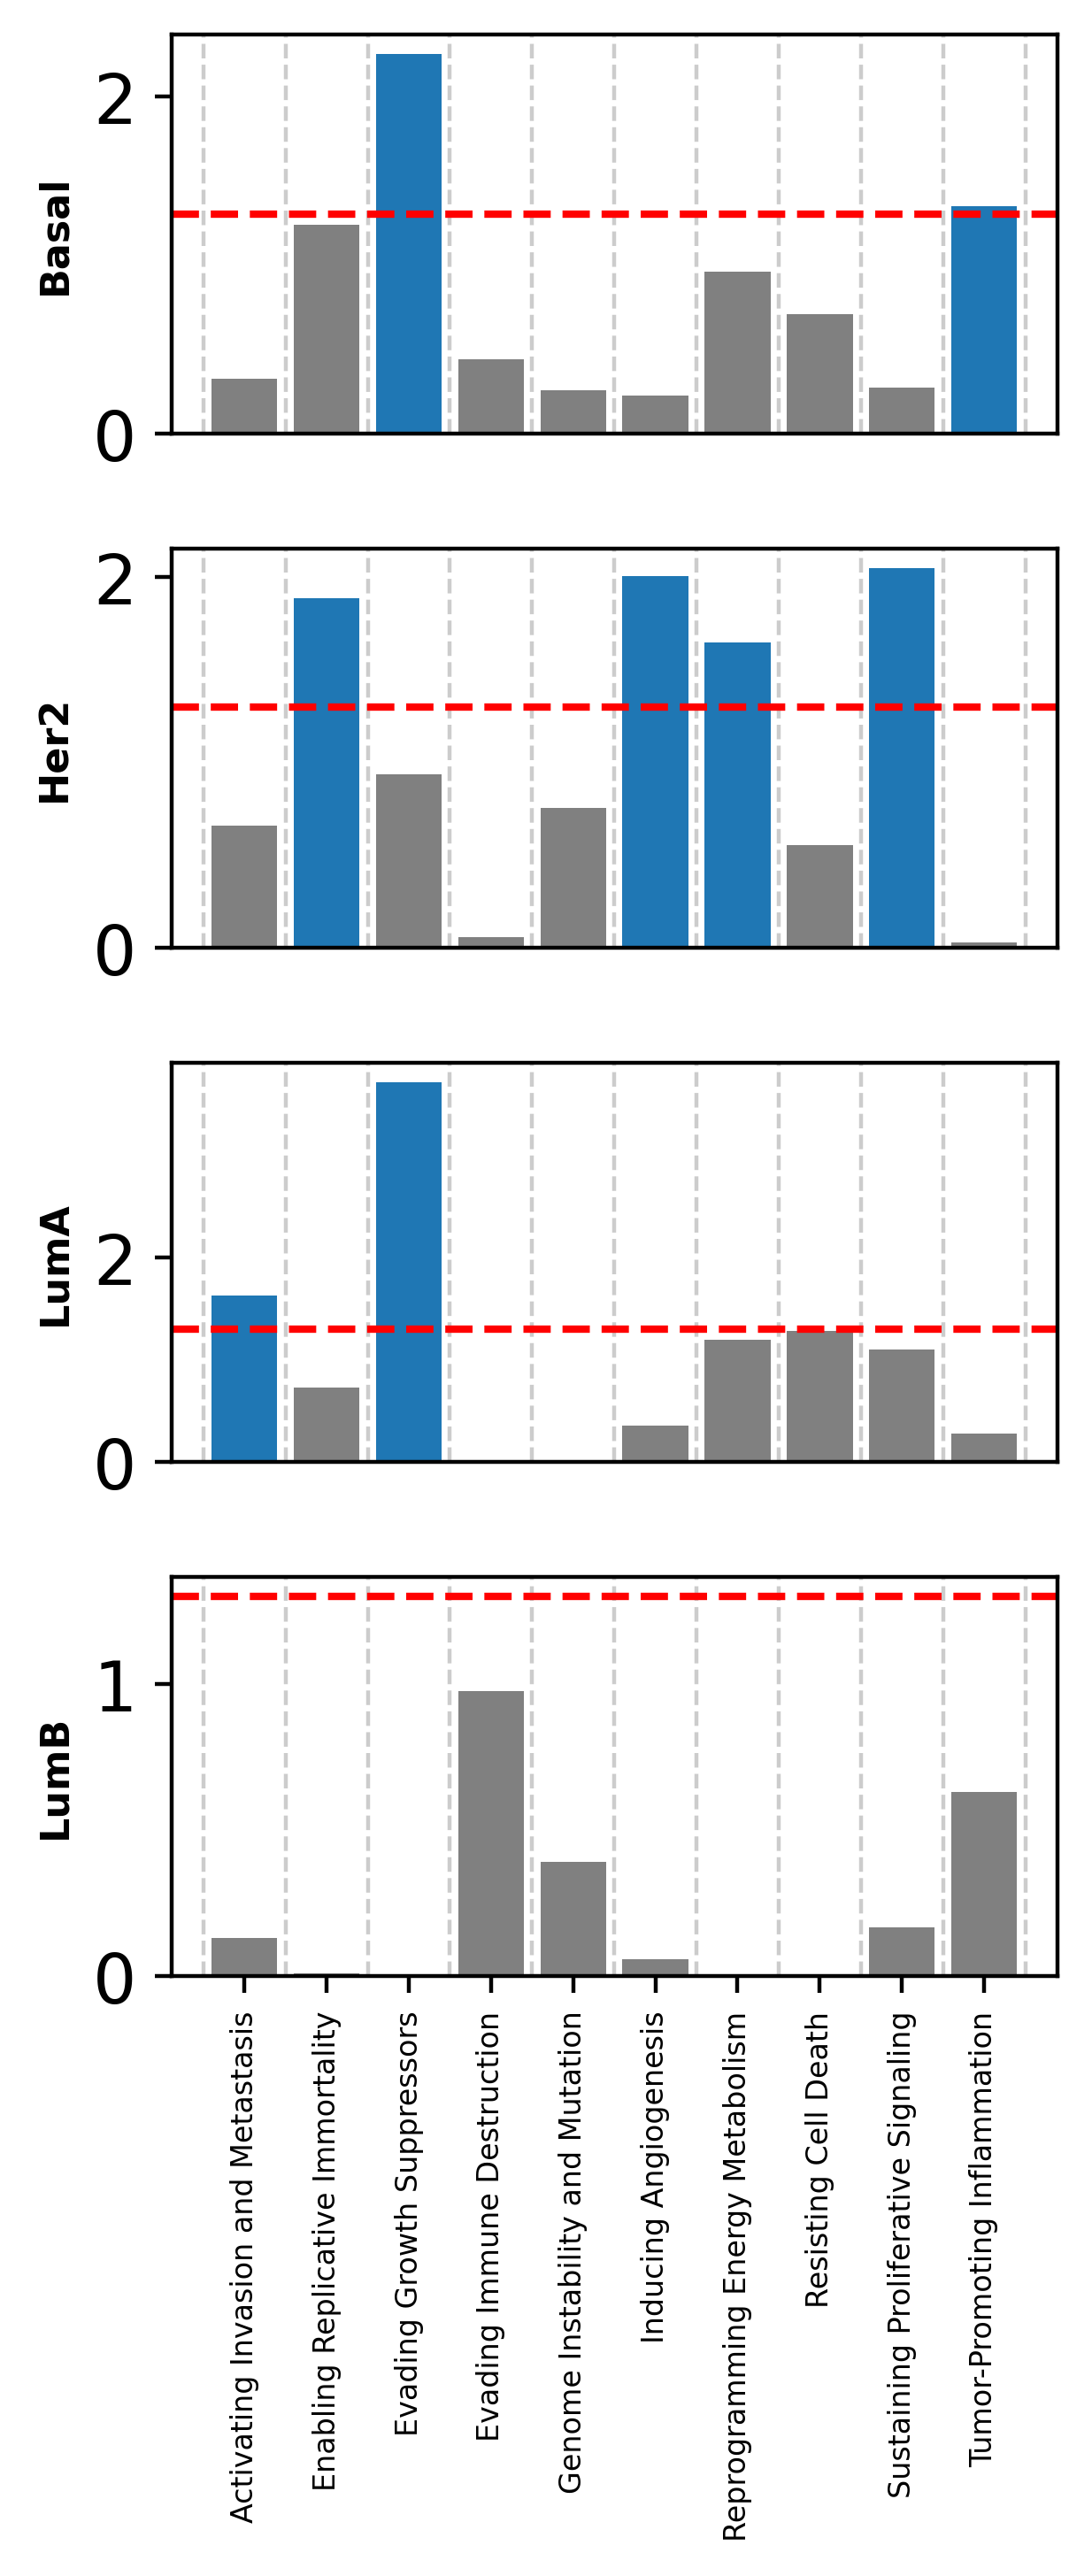

In [62]:
import matplotlib.pyplot as plt
series_dict = dict([(s, enrich_per_subtype[s]["P(Beta > 0)"]) for s in enrich_per_subtype.keys()])
# Create the complete index list
index_list = []
for analysis in series_dict.values():
    index_list.extend(analysis.index.tolist())
index_list = list(set(index_list))

# Update each series to have the complete index
for name, analysis in series_dict.items():
    for index in index_list:
        if index not in analysis:
            series_dict[name][index] = 1

# Create subplots
fig, axs = plt.subplots(len(series_dict), 1, sharex=True, figsize=(3.5, 7.5))

# Plot each analysis
for i, (ax, (name, analysis)) in enumerate(zip(axs, series_dict.items())):
    analysis = (-np.log10(analysis)).sort_index()
    bar_colors = [(0.12156862745098039, 0.4666666666666667, 0.7058823529411765) if p > -np.log10(0.05) else (0.5,0.5,0.5) for p in analysis.values]
    ax.bar(analysis.index, analysis.values, color=bar_colors, width=0.8)
    ax.set_xlim(ax.get_xlim()[0], ax.get_xlim()[1])
    ax.hlines(-np.log10(0.05), ax.get_xlim()[0], ax.get_xlim()[1], color="red", linestyle="dashed")
    # ax.set_title(name, fontweight="heavy")
    ax.set_ylabel(name, fontweight="heavy", fontsize=8)
    ax.tick_params(which='minor', bottom=False)
    if i != len(series_dict) - 1:  # if not the last subplot
        ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    else:  # if the last subplot
        ax.tick_params(axis='x', rotation=90, labelsize=6)
    ax.set_xticks(np.arange(-0.5, len(analysis.index) + 0.5, 1), minor=True)  # set x ticks for minor grid
    ax.grid(False)
    ax.grid(which='minor', axis='x', linestyle="dashed")

plt.tight_layout()
plt.savefig("atac_tcga_results/hallmark_enrich.pdf", bbox_inches="tight")
plt.show()

In [63]:
enricher_hallmarks.mat

ABL1  ABL2  ACP1  ACTB  ACTG1  ACTN1  \
Activating Invasion and Metastasis     1     1     1     1      1      1   
Enabling Replicative Immortality       0     0     0     0      0      0   
Evading Growth Suppressors             1     1     0     1      1      0   
Evading Immune Destruction             0     0     0     1      1      1   
Genome Instability and Mutation        0     0     0     0      0      0   
Inducing Angiogenesis                  0     0     0     1      1      0   
Reprogramming Energy Metabolism        0     0     0     0      0      0   
Resisting Cell Death                   1     1     0     1      1      0   
Sustaining Proliferative Signaling     1     1     1     1      1      1   
Tumor-Promoting Inflammation           0     0     0     1      1      1   

                                    ACTN2  ACTN3  ACTN4  ACVR1  ...  \
Activating Invasion and Metastasis      1      1      1      1  ...   
Enabling Replicative Immortality        0      0      0      1  ...   
Evading Growth Suppressors              0      0      0      1  ...   
Evading Immune Destruction              1      1      1      0  ...   
Genome Instability and Mutation         0      0      0      0  ...   
Inducing Angiogenesis                   0      0      0      1  ...   
Reprogramming Energy Metabolism         0      0      0      0  ...   
Resisting Cell Death                    0      0      0      1  ...   
Sustaining Proliferative Signaling      1      1      1      1  ...   
Tumor-Promoting Inflammation            1      1      1      0  ...   

                                    bP-2168N6.3  bP-2171C21.2  bP-2171C21.3  \
Activating Invasion and Metastasis            0             0             0   
Enabling Replicative Immortality              0             0             0   
Evading Growth Suppressors                    0             0             0   
Evading Immune Destruction                    0             0             0   
Genome Instability and Mutation               0             0             0   
Inducing Angiogenesis                         0             0             0   
Reprogramming Energy Metabolism               0             0             0   
Resisting Cell Death                          0             0             0   
Sustaining Proliferative Signaling            0             0             0   
Tumor-Promoting Inflammation                  0             0             0   

                                    bP-2171C21.5  bP-2189O9.2  bP-2189O9.5  \
Activating Invasion and Metastasis             0            0            0   
Enabling Replicative Immortality               0            0            0   
Evading Growth Suppressors                     0            0            0   
Evading Immune Destruction                     0            0            0   
Genome Instability and Mutation                0            0            0   
Inducing Angiogenesis                          0            0            0   
Reprogramming Energy Metabolism                0            0            0   
Resisting Cell Death                           0            0            0   
Sustaining Proliferative Signaling             0            0            0   
Tumor-Promoting Inflammation                   0            0            0   

                                    hsa-mir-1253  hsa-mir-423  snoZ196  \
Activating Invasion and Metastasis             0            0        0   
Enabling Replicative Immortality               0            0        0   
Evading Growth Suppressors                     0            0        0   
Evading Immune Destruction                     0            0        0   
Genome Instability and Mutation                0            0        0   
Inducing Angiogenesis                          0            0        0   
Reprogramming Energy Metabolism                0            0        0   
Resisting Cell Death                           0            0        0   
Sustaining Proliferati